In [49]:
import os
print(os.getcwd())

# 작업 디렉토리 변경
os.chdir('/content/drive/MyDrive/Colab Notebooks/graduateProject')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/graduateProject
/content/drive/MyDrive/Colab Notebooks/graduateProject


In [72]:
# 필요한 라이브러리 임포트
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib
import sys
import os
import random

# 캐싱된 모듈 삭제
if 'models' in sys.modules:
    del sys.modules['models']
if 'Segdataset' in sys.modules:
    del sys.modules['Segdataset']

# 다시 임포트
from models import CNN,RNN,Transformer  # CNN 모델 클래스 임포트
from Segdataset import SegDataset,read_file_list  # 데이터셋 로드 클래스
from torch.utils.data import DataLoader, WeightedRandomSampler

In [77]:
# 설정값 정의
data_root = '/content/drive/MyDrive/Colab Notebooks/graduateProject/data/TESS'
save_root = '/content/drive/MyDrive/Colab Notebooks/graduateProject/model/checkpoints'
og_root = save_root + '/model.pth'  # 저장된 모델 경로
num_epochs =100
learning_rate = 2e-4
batch_size = 128
num_workers = 2
random_seed = 42
model_kind = 'transformer'  # 모델 종류
is_shuffle_dataset = True  # 데이터 셔플 여부
test_split = 0.2  # 테스트 데이터 비율
n_mfcc = 16

In [74]:
# 사용 가능한 디바이스 설정
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"using device : {device}")

using device : cuda


In [78]:
if model_kind == 'rnn':
     model = RNN(n_mfcc)
elif model_kind == 'transformer':
     model = Transformer(n_mfcc)
elif model_kind == 'cnn':
     model = CNN()

print(model)

Transformer(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (linear1): Linear(in_features=16, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=16, bias=True)
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2)

In [ ]:
# SegDataset 클래스를 사용하여 학습 및 검증 데이터셋을 생성
train_data, val_data = read_file_list(root=data_root, n_mfcc=16, random_state=42, test_size=0.25)
train = SegDataset(train_data)
val= SegDataset(val_data)
train_iter = torch.utils.data.DataLoader(train, batch_size, shuffle=is_shuffle_dataset, drop_last=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(val, batch_size, drop_last=True, num_workers=num_workers)

In [ ]:
import pickle

# 데이터를 파일로 저장
with open('/content/drive/MyDrive/train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

with open('/content/drive/MyDrive/val_data.pkl', 'wb') as f:
    pickle.dump(val_data, f)


In [79]:
def custom_collate_fn(batch):
    mfccs = [item[0] for item in batch]
    emotions = [item[1] for item in batch]

    # 텐서 크기 맞추기 (패딩, 또는 자르기 방식)
    # 예시로 모든 데이터를 같은 크기로 패딩 처리
    mfccs = torch.nn.utils.rnn.pad_sequence(mfccs, batch_first=True)
    emotions = torch.tensor(emotions)

    return mfccs, emotions


In [80]:
import pickle

# 저장된 데이터를 다시 불러오기
with open('/content/drive/MyDrive/train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('/content/drive/MyDrive/val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)

# SegDataset으로 다시 Dataset 객체 생성
train = SegDataset(train_data)
val = SegDataset(val_data)

# DataLoader 생성
train_iter = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=is_shuffle_dataset, drop_last=True, num_workers=num_workers, collate_fn=custom_collate_fn)
test_iter = torch.utils.data.DataLoader(val, batch_size=batch_size, drop_last=True, num_workers=num_workers, collate_fn=custom_collate_fn)


Read 1800 examples.
Read 600 examples.


In [81]:
all_train_epoch_loss = []
all_test_epoch_loss = []
all_test_epoch_accuracy_emotion=[]
model = model.to(device)

pos_weight = torch.tensor([0.75]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)    #Binary Cross Entropy with Logits Loss 활성화 함수 이용

optimizer = optim.Adam(model.parameters(), learning_rate)

In [82]:
for epo in range(num_epochs):
    train_loss = 0
    model.train()  # batch normalization , dropout 활성화

    for index, (mfcc, emotion) in enumerate(train_iter):
        mfcc, emotion =mfcc.to(device), emotion.to(device)
        optimizer.zero_grad()
        output_emotion = model(mfcc)

        emotion = emotion.float()

        loss = criterion(output_emotion[:, 0].squeeze(), emotion)
        loss.backward()
        iter_loss = loss.item()
        train_loss += iter_loss
        optimizer.step()

        if np.mod(index, 15) == 0:
            print('epoch {}, {}/{},train loss is {}'.format(epo, index, len(train_iter), iter_loss))

    # test
    test_loss = 0
    correct_emotion = 0
    total=0
    model.eval()
    with torch.no_grad():
        for index, (mfcc, emotion) in enumerate(test_iter):
            mfcc, emotion = mfcc.to(device), emotion.to(device)
            optimizer.zero_grad()
            output_emotion = model(mfcc)
            emotion = emotion.float()

            loss = criterion(output_emotion[:, 0].squeeze(), emotion)
            test_loss += loss.item()

            predicted_emotion = (output_emotion[:, 0] > 0.5).float()
            correct_emotion += (predicted_emotion == emotion).sum().item()
            total += emotion.size(0)
    accuracy_emotion = (correct_emotion / total)
    print('<---------------------------------------------------->')
    print('epoch: %f' % epo)
    print('epoch train loss = %f, epoch test loss = %f,accuracy_emotion =%.3f'
          % (train_loss / len(train_iter), test_loss / len(test_iter),accuracy_emotion))

    if np.mod(epo, 1) == 0:
        torch.save(model.state_dict(), save_root+'/ep%03d-loss%.3f-val_loss%.3f.pth' % (
            (epo + 1), (train_loss / len(train_iter)), (test_loss / len(test_iter)))
                    )
        print('saving checkpoints/model_{}.pth'.format(epo))
    all_test_epoch_accuracy_emotion.append(accuracy_emotion)
    all_train_epoch_loss.append(train_loss / len(train_iter))
    all_test_epoch_loss.append(test_loss / len(test_iter))

epoch 0, 0/14,train loss is 0.6320763230323792
<---------------------------------------------------->
epoch: 0.000000
epoch train loss = 0.629811, epoch test loss = 0.619188,accuracy_emotion =0.502
saving checkpoints/model_0.pth
epoch 1, 0/14,train loss is 0.61411452293396
<---------------------------------------------------->
epoch: 1.000000
epoch train loss = 0.616554, epoch test loss = 0.614581,accuracy_emotion =0.502
saving checkpoints/model_1.pth
epoch 2, 0/14,train loss is 0.6165181398391724
<---------------------------------------------------->
epoch: 2.000000
epoch train loss = 0.613607, epoch test loss = 0.613120,accuracy_emotion =0.502
saving checkpoints/model_2.pth
epoch 3, 0/14,train loss is 0.6228903532028198
<---------------------------------------------------->
epoch: 3.000000
epoch train loss = 0.612463, epoch test loss = 0.612533,accuracy_emotion =0.502
saving checkpoints/model_3.pth
epoch 4, 0/14,train loss is 0.6105524301528931
<--------------------------------------

In [ ]:
import matplotlib.pyplot as plt

# 여러 그래프를 한 화면에 출력
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열로 그래프 배치

# 학습 및 테스트 손실 그래프 (한 화면에)
axs[0].plot(all_train_epoch_loss, label='Train Loss')
axs[0].plot(all_test_epoch_loss, label='Test Loss')
axs[0].set_title('Train and Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 테스트 정확도 그래프
axs[1].plot(all_test_epoch_accuracy_emotion)
axs[1].set_title('Test Accuracy Emotion')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 출력
plt.savefig(save_root + '/training_results_combined.png')  # 하나의 파일로 저장
plt.show()  # 화면에 출력


accuracy: 0.6516666666666666
precision: [0.731 0.613]
recall: [0.48  0.823]
f1 score: [0.579 0.703]


<Figure size 640x480 with 0 Axes>

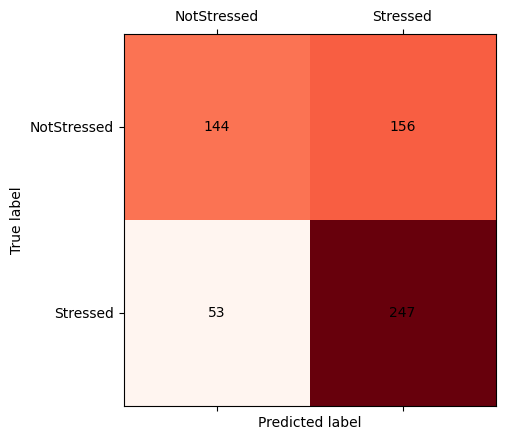

In [84]:
import matplotlib.pyplot as plt
from models import *
from Segdataset import SegDataset
import argparse
from utils import plot_confusion_matrix, get_evaluation
from torch.utils.data import DataLoader
import os
import numpy as np

emotions = ['NotStressed', 'Stressed']

output_emotion_list = []
label_emotion_list = []

test_iter = torch.utils.data.DataLoader(val, batch_size=1, drop_last=True, num_workers=num_workers)

model.eval()

with torch.no_grad():
  for index, (mfcc, emotion) in enumerate(test_iter):
      mfcc, emotion = mfcc.to(device), emotion.to(device)

      output_emotion = model(mfcc)
      output_emotion = output_emotion.float()  # mps -> 시그모이드 함수 int64 지원 안 함 ->float으로 변환
      output_emotion = torch.sigmoid(output_emotion)

      # 0.56 기준으로 이진 분류
      predicted_emotion = (output_emotion > 0.56).float()

      # 리스트에 저장
      output_emotion_list.append(predicted_emotion.cpu().numpy())
      label_emotion_list.append(emotion.cpu().numpy())

# 리스트를 numpy 배열로 변환 및 차원 축소
output_emotion_list = np.vstack(output_emotion_list)  # 2차원 배열을 만들기 위해 vstack 사용
label_emotion_list = np.vstack(label_emotion_list)

# 차원 맞추기 (output_emotion_list의 두 번째 열 선택하여 1차원으로)
output_emotion_list = output_emotion_list[:, 0]
label_emotion_list = label_emotion_list[:, 0]

# 평가
acc, precision, recall, f1 = get_evaluation(label_emotion_list, output_emotion_list)

print('accuracy:', acc)
print('precision:', precision)
print('recall:', recall)
print('f1 score:', f1)


# Confusion Matrix 생성 및 저장
plot_confusion_matrix(label_emotion_list, output_emotion_list, emotions)


# Result

# CNN : 100 epoch

accuracy: 0.7966666666666666    
precision: [0.713 0.989]    
recall: [0.993 0.6 ]    
f1 score: [0.83 0.747]     

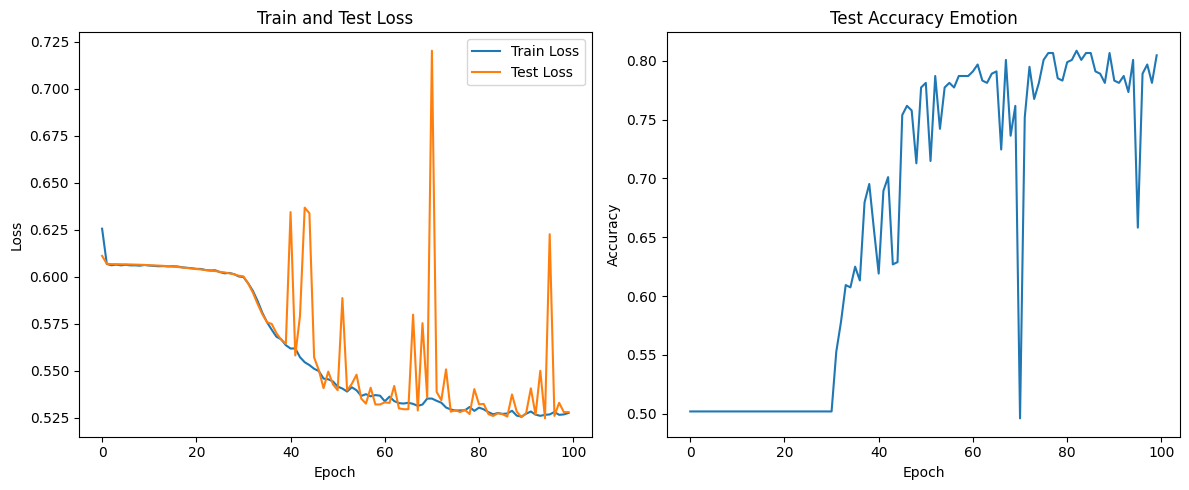

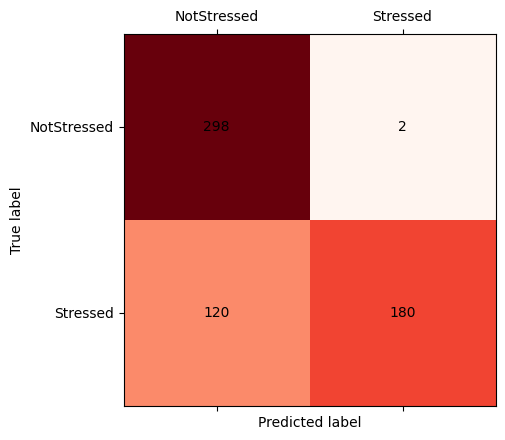

CNN : 500 epoch
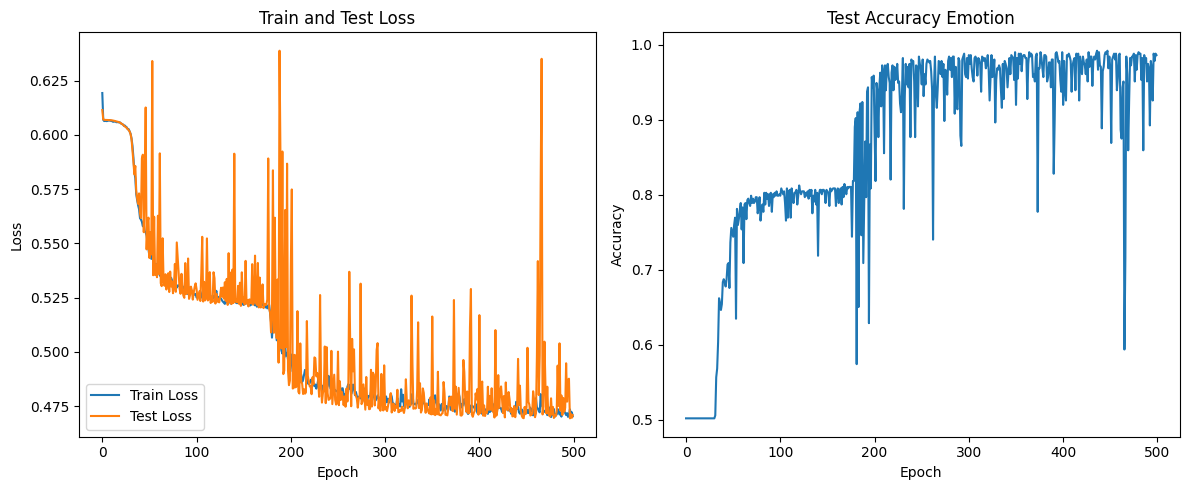

# RNN : 100 epoch

accuracy: 0.9833333333333333   
precision: [0.99  0.977]   
recall: [0.977 0.99 ]    
f1 score: [0.983 0.983]   

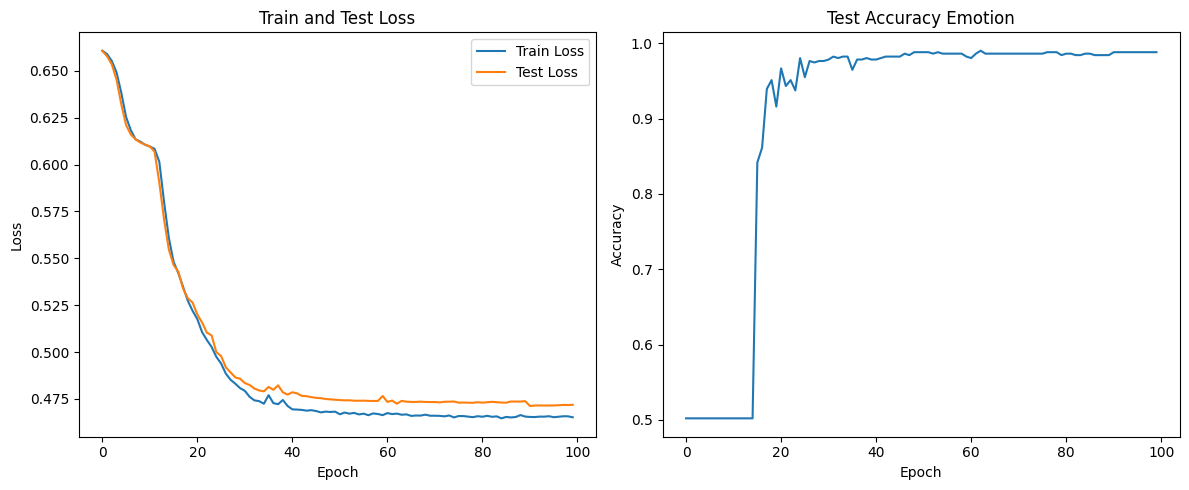

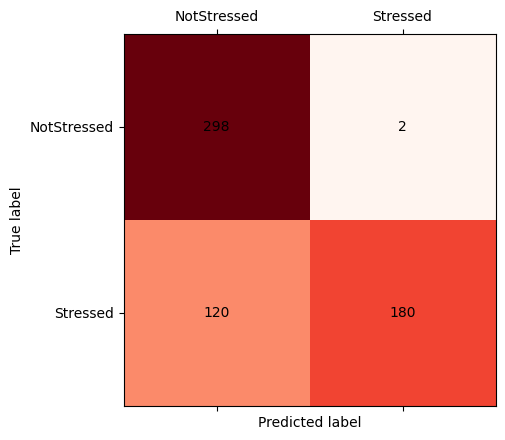

# RNN : 500 epoch
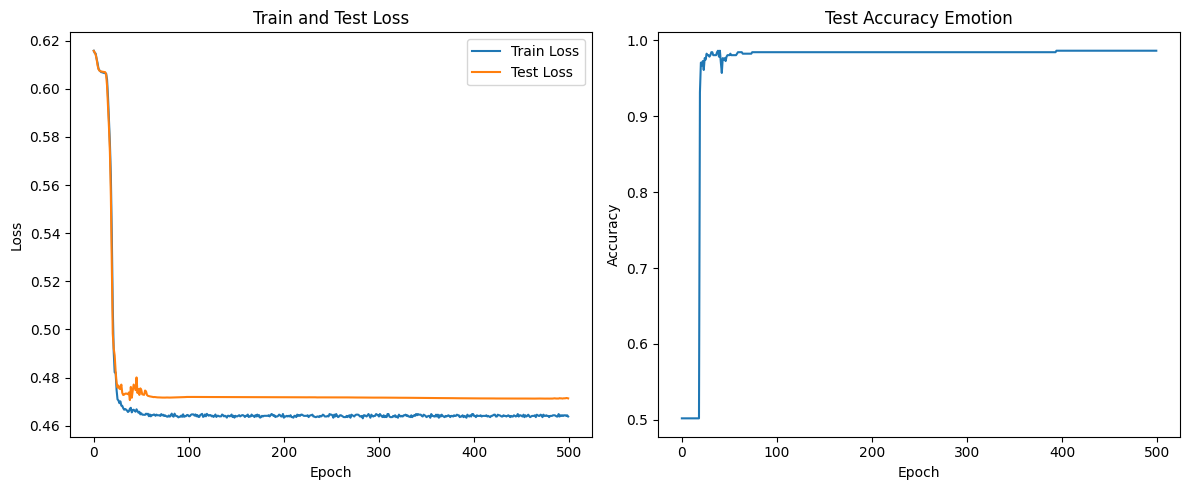

# Transfomer : 100 epoch

accuracy: 0.6516666666666666    
precision: [0.731 0.613]    
recall: [0.48  0.823]     
f1 score: [0.579 0.703]   


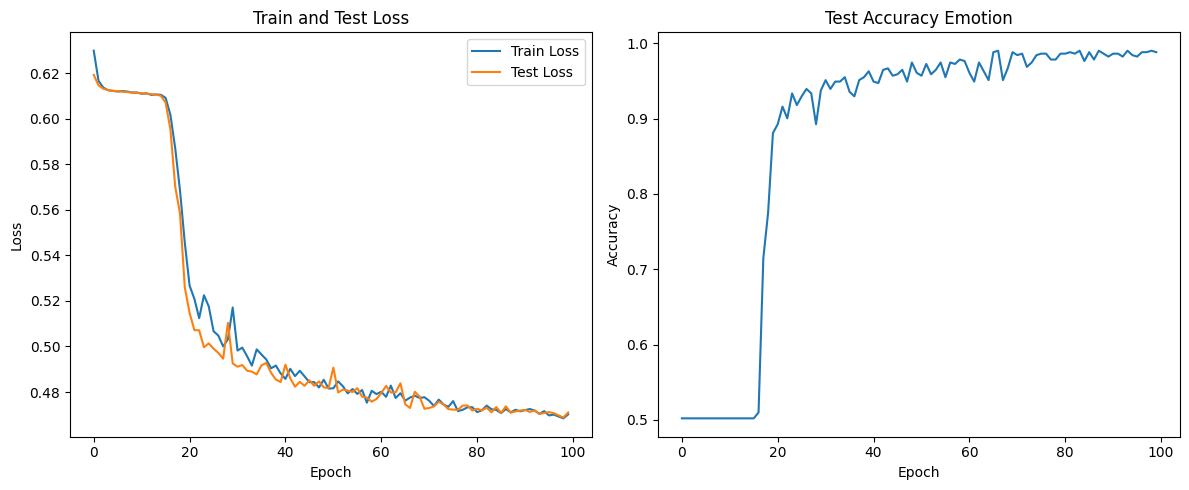

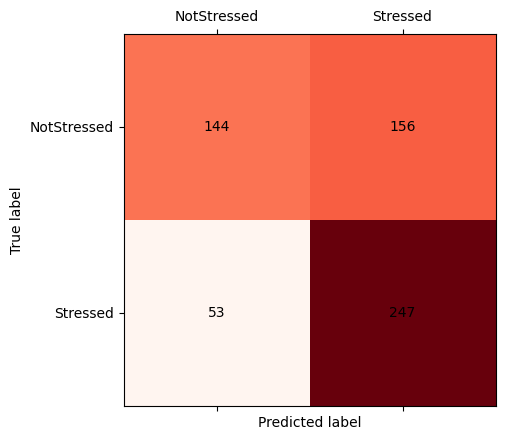